In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy, MSE
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [2]:
# df = pd.read_csv('./CUB_200_2011/CUB_200_2011/images.txt', delim_whitespace=True, header=None)
# df = df.drop(0, 1)

In [3]:
# df.columns = ['path']

In [4]:
# df.path[0]

In [5]:
# df[['class', 'junk']] = df['path'].str.split('/', expand=True)

In [6]:
# df[['class_number', 'junk']] = df['class'].str.split('.', expand=True)

In [7]:
# df['image_number'] = df.index + 1

In [8]:
# df = df.drop('junk', 1)

In [9]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [10]:
# train_datagen = ImageDataGenerator(preprocessing_function=normalize_img)

In [11]:
# train_generator = train_datagen.flow_from_dataframe(
#         dataframe=df,
#         directory='./CUB_200_2011/CUB_200_2011/images/',
#         x_col="path",
#         y_col="class_number",
#         target_size=(64, 64),
#         batch_size=32,
#         class_mode='categorical',
#         save_to_dir='./CUB_200_2011/CUB_200_2011/images-cleaned/')

In [12]:
# for cls in df['class'].unique():
#     path = './CUB_200_2011/CUB_200_2011/images-cleaned/' + str(cls)
#     if not os.path.exists(path):
#         os.makedirs(path)

In [13]:
# for cls in df['class'].unique():
#     path = './CUB_200_2011/CUB_200_2011/images-cleaned/' + str(cls)
#     train_generator = train_datagen.flow_from_dataframe(
#         dataframe=df,
#         directory='./CUB_200_2011/CUB_200_2011/images/',
#         x_col="path",
#         y_col="class",
#         target_size=(64, 64),
#         batch_size=100,
#         class_mode='categorical',
#         classes = [str(cls)],
#         save_to_dir=path)
#     train_generator.next()

In [316]:
train_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))

train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5

In [116]:
def make_generator_model(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(16*16*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 64))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [117]:
generator = make_generator_model((200,))
generator.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
dense_70 (Dense)             (None, 16384)             3293184   
_________________________________________________________________
batch_normalization_127 (Bat (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_226 (LeakyReLU)  (None, 16384)             0         
_________________________________________________________________
reshape_22 (Reshape)         (None, 16, 16, 64)        0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_105 (Conv2D (None, 32, 32, 32)        184

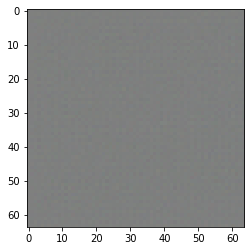

In [118]:
generator = make_generator_model((200,))

noise = np.random.normal(0, 1, 200)

generated_image = generator.predict(np.array([noise]))[0]
plt.imshow(unnormalize_img(generated_image), )

In [151]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    
    return Model(input_layer, x)

In [152]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator.predict(np.array([generated_image]))
print (decision)

Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_291 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_155 (Dropout)        (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_292 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_156 (Dropout)        (None, 32, 32, 64)        0  

In [360]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * tf.constant(0.9), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [174]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [175]:
def generator_mse_loss(real_img, gen_img):
    return MSE(real_img, gen_img)

In [176]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [364]:
@tf.function
def train_step(images):
#     noise = tf.random.normal([32, 200])
    noise = tf.random.truncated_normal([32, 200])
    
    gen_losses = []
    disc_losses = []
    mse_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        mse_loss = tf.reduce_mean(generator_mse_loss(images, generated_images))
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))
        mse_losses.append(K.mean(mse_loss))
        final_gen_loss = gen_loss + mse_loss

#     do_train = sum(disc_losses)/len(disc_losses) > 0.
        
    gradients_of_generator = gen_tape.gradient(final_gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
#     if do_train:
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        
    return (gen_losses, disc_losses, mse_losses)

In [365]:
def train(train_imgs, epochs):
    gen_loss_all = []
    disc_loss_all = []
    mse_loss_all = []
    
    num_imgs = len(train_imgs)
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        mse_loss_epoch = [1, 0]
        
        np.random.shuffle(train_imgs)
        
        for i in range(0, num_imgs - 32, 32):
            gen_loss_batch, disc_loss_batch, mse_loss_batch = train_step(train_imgs[i:(i+32)])

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            mse_loss_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            mse_loss_epoch[1] += np.mean(mse_loss_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, MSE loss: {mse_loss_epoch[1]/mse_loss_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        mse_loss_all.append(mse_loss_epoch[1]/mse_loss_epoch[0])
    
    return (gen_loss_all, disc_loss_all, mse_loss_all)
    


In [363]:
discriminator = make_discriminator_model()
generator = make_generator_model((200,))
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 14.474692583084106 sec
Gen loss: 5.621554217687467, Disc loss: 0.4051119282155179, MSE loss: 0.604354115036445
Time for epoch 2 is 12.533450365066528 sec
Gen loss: 7.127312638572238, Disc loss: 0.3704842652893325, MSE loss: 0.7372936593484749
Time for epoch 3 is 13.142885208129883 sec
Gen loss: 7.567805772874413, Disc loss: 0.3462174382151627, MSE loss: 0.855285734665103
Time for epoch 4 is 12.757451057434082 sec
Gen loss: 7.545214455948289, Disc loss: 0.34073317373994244, MSE loss: 

Time for epoch 58 is 13.076642990112305 sec
Gen loss: 4.722295713295458, Disc loss: 0.468362076414956, MSE loss: 0.47162958729234816
Time for epoch 59 is 13.009662866592407 sec
Gen loss: 4.4222948014897705, Disc loss: 0.5017302695328627, MSE loss: 0.46455767395373604
Time for epoch 60 is 13.079830884933472 sec
Gen loss: 4.590379831913687, Disc loss: 0.46646144162348613, MSE loss: 0.46188373237767516
Time for epoch 61 is 13.156991720199585 sec
Gen loss: 4.456658595299656, Disc loss: 0.49230125724138607, MSE loss: 0.45506438572555374
Time for epoch 62 is 13.003458261489868 sec
Gen loss: 4.680155091815525, Disc loss: 0.4777287676082394, MSE loss: 0.4898487253563837
Time for epoch 63 is 13.05347204208374 sec
Gen loss: 4.605039386568354, Disc loss: 0.4883341400765468, MSE loss: 0.4857203084117352
Time for epoch 64 is 13.532156467437744 sec
Gen loss: 4.723176531029265, Disc loss: 0.47394679062734774, MSE loss: 0.4674458352692405
Time for epoch 65 is 12.977713584899902 sec
Gen loss: 4.5675325

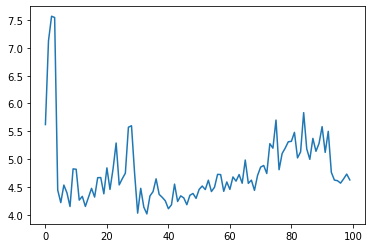

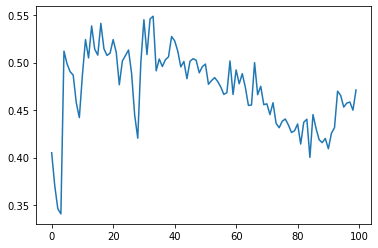

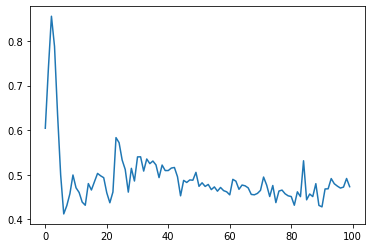

In [366]:
gen_hist, disc_hist, mse_hist = train(train_imgs, 100)

plt.plot(gen_hist)
plt.show()

plt.plot(disc_hist)
plt.show()

plt.plot(mse_hist)
plt.show()

In [ ]:
noise = np.random.normal(0, 1, 200)

gen_loss_hist = []
disc_loss_hist = []
mse_loss_hist = []

for i in range(10):
    gen_temp, disc_temp, mse_temp = train(train_imgs, 100)
    gen_loss_hist += gen_temp
    disc_loss_hist += disc_temp
    mse_loss_hist += mse_temp
    generated_image = generator.predict(np.array([noise]))[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.savefig('./results/prog-imgs/bird-gan-deeper-mse/' + str((i+1)*100) + '.png')
    plt.show()
    generator.save_weights('./results/weights/bird-gan-deeper-mse/gen_weights_deeper_mse_' + str((i+1)*100) + '.h5')
    discriminator.save_weights('./results/weights/bird-gan-deeper-mse/disc_weights_deeper_mse_' + str((i+1)*100) + '.h5')

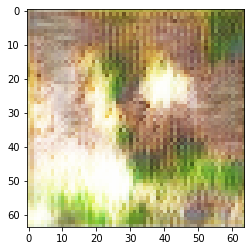

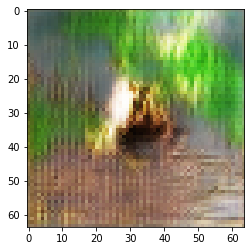

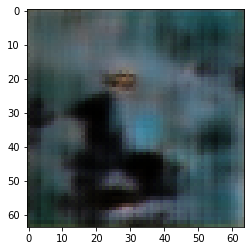

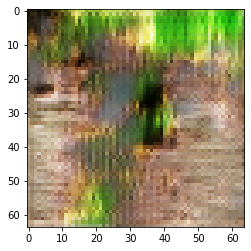

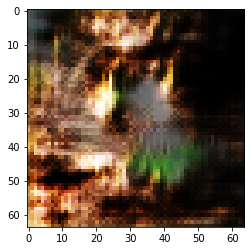

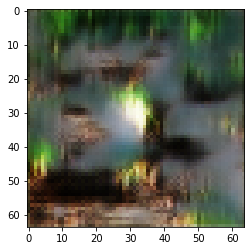

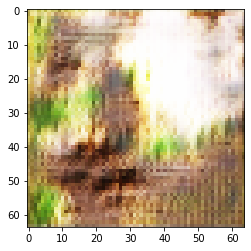

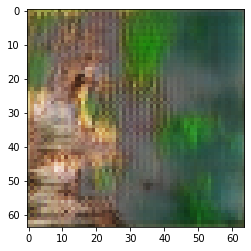

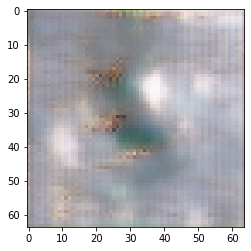

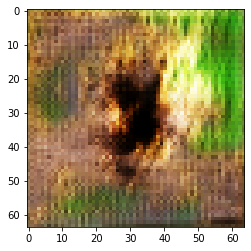

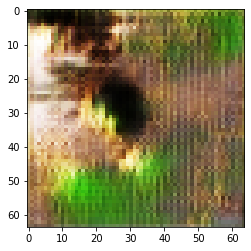

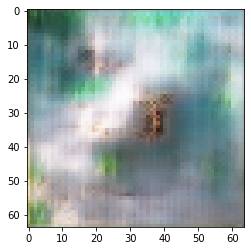

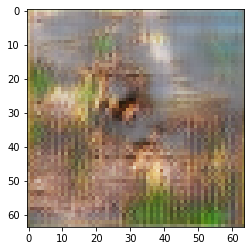

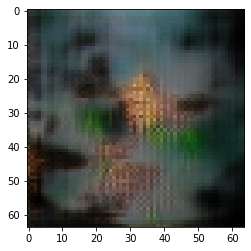

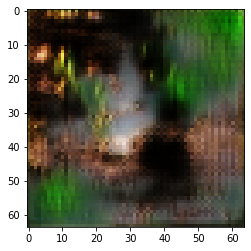

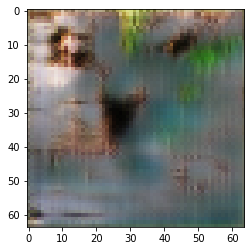

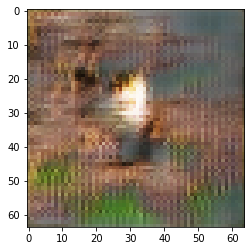

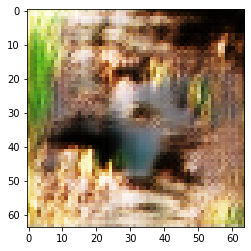

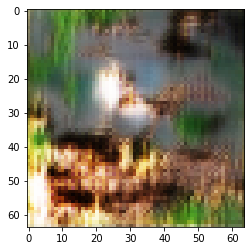

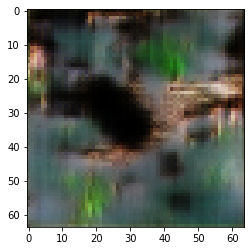

In [367]:
for i in range(20):
    noise = np.random.normal(0, 1, 200)

    generated_image = generator.predict(np.array([noise]))[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()